In [158]:
tag = "IPDP"

In [159]:
catdict = {
    r"$\mu-\pi$"     : 20014002,
    r"$\mu-\rho$"    : 20014004,
    r"$\mu-a^{1}_{3\pi}$" : 20014008,
}
shiftdict = {
    "cp_even" : 150,
    "cp_odd"  : 151,
    "maxmix"  : 0,
}
simpledict = {
    r"$\mu-\pi$"     : "mupi",
    r"$\mu-\rho$"    : "murho",
    r"$\mu-a^{1}_{3\pi}$" : "mua13pr",
}

In [160]:
import os
import re
#import ROOT
import hist
import pickle
import mplhep as hep
from glob import glob
import numpy as np
import awkward as ak
from tabulate import tabulate
from IPython import embed
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
# iminuit
import iminuit
from iminuit import Minuit
from iminuit.cost import LeastSquares
hep.style.use("CMS")
print("iminuit version:", iminuit.__version__)

iminuit version: 2.30.1


In [161]:
def comp_asymmetry(arr1, arr2):
    # https://github.com/Ksavva1021/TIDAL/blob/656f992ae056b3fed0061f2b3efb49905c39834d/CP_Tools/scripts/assymetry.py#L26
    return (1/arr1.size)*np.sum(np.abs((arr1-arr2)/(arr1+arr2)))

In [162]:
def makesimple(latex_str):
    # Remove LaTeX commands (e.g., $...$, \frac, \text, etc.)
    plain_text = re.sub(r'\\[a-zA-Z]+\{[^}]*\}', '', latex_str)  # Remove \command{...}
    print(plain_text)
    plain_text = re.sub(r'\$.*?\$', '', plain_text)  # Remove math expressions between $...$
    print(plain_text)
    plain_text = re.sub(r'\\[a-zA-Z]+', '', plain_text)  # Remove other LaTeX commands (e.g., \chi)
    print(plain_text)

    # Clean up any remaining special characters
    plain_text = plain_text.replace('$', '')  # Remove leftover dollar signs
    print(plain_text)    
    return plain_text

In [163]:
np.linspace(0., 10., 20)

array([ 0.        ,  0.52631579,  1.05263158,  1.57894737,  2.10526316,
        2.63157895,  3.15789474,  3.68421053,  4.21052632,  4.73684211,
        5.26315789,  5.78947368,  6.31578947,  6.84210526,  7.36842105,
        7.89473684,  8.42105263,  8.94736842,  9.47368421, 10.        ])

In [164]:
file = f"INPUT/shifted_hist__PhiCPGen_{tag}.pickle"

In [165]:
fileptr = open(file, 'rb')
data = pickle.load(fileptr)
fileptr.close()

In [166]:
data

Hist(
  IntCategory([1e+07, 200000, 1e+06, 3e+06, 15000, 300000, 10000, 11000, 16000, 2.0014e+07, 6000, 2.0014e+07, 1, 4.0013e+07, 2.0014e+07, 100000, 9000, 4.0013e+07, 12000, 4.0013e+07, 4.0013e+07, 7000, 4000, 2.0014e+07, 8000, 3000, 2000, 4e+06, 1000, 2e+06, 5000], growth=True, name='category'),
  IntCategory([11100], growth=True, name='process'),
  IntCategory([0, 150, 151], growth=True, name='shift'),
  Variable([0, 0.314159, 0.628319, 0.942478, 1.25664, 1.5708, 1.88496, 2.19911, 2.51327, 2.82743, 3.14159, 3.45575, 3.76991, 4.08407, 4.39823, 4.71239, 5.02655, 5.34071, 5.65487, 5.96903, 6.28319], name='PhiCPGen_IPDP', label='$\\Phi_{CP}^{IP-NP}$ (rad) [Gen level]'),
  storage=Weight()) # Sum: WeightedSum(value=13522.5, variance=64.9478)

In [167]:
axes = data.axes
category_axis  = axes['category']
category_axis

IntCategory([1e+07, 200000, 1e+06, 3e+06, 15000, 300000, 10000, 11000, 16000, 2.0014e+07, 6000, 2.0014e+07, 1, 4.0013e+07, 2.0014e+07, 100000, 9000, 4.0013e+07, 12000, 4.0013e+07, 4.0013e+07, 7000, 4000, 2.0014e+07, 8000, 3000, 2000, 4e+06, 1000, 2e+06, 5000], growth=True, name='category')

In [168]:
shift_axis = axes['shift']
shift_axis

IntCategory([0, 150, 151], growth=True, name='shift')

In [169]:
cparray = {}
for ckey, cval in catdict.items():
    shiftarray = {}
    for key,val in shiftdict.items():
        if cval not in category_axis:
            print(f"WARNING : {cval} not in categories")
            continue
        values = data[category_axis.index(cval), :, shift_axis.index(val), :].values()
        # https://github.com/oponcet/CPinHToTauTau/blob/FF_dev_project/script_FF/fake_factor_derivation/src/input_processing.py#L133
        errors = data[category_axis.index(cval), :, shift_axis.index(val), :].variances() ** 0.5
        #shiftarray[key] = data[category_axis.index(cval), :, shift_axis.index(val), :].values()
        shiftarray[key] = [values, errors]
    cparray[ckey] = shiftarray
#cparray

$\mu-\pi$
$\mu-\rho$


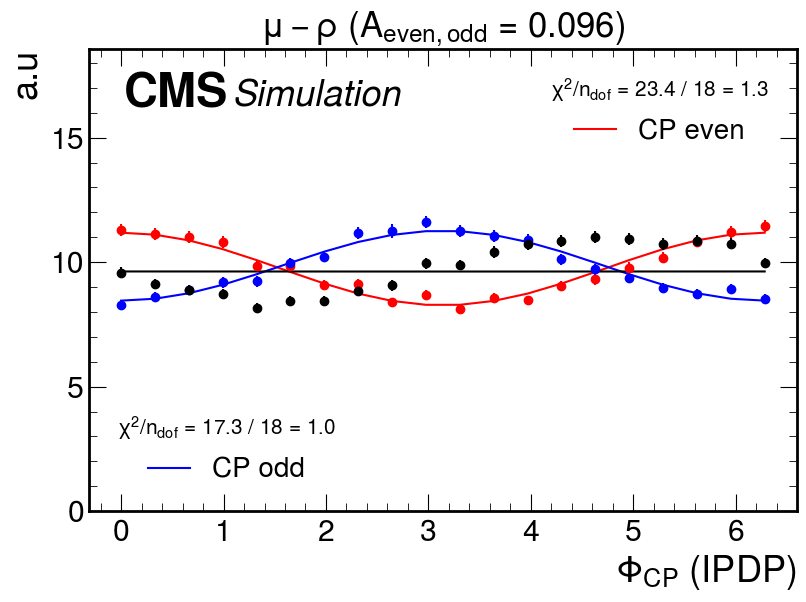

$\mu-a^{1}_{3\pi}$


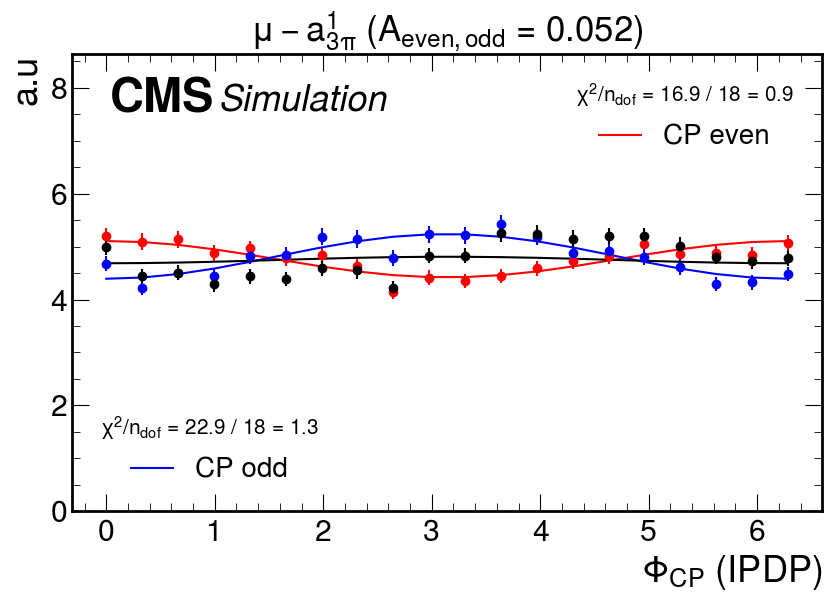

In [170]:
cpfitarray = {}
x = np.linspace(0., 2*np.pi, 20)
def model(x, a, b):
    return a*np.cos(x) + b

def fit(x, y, err=0.05, model=model):
    lsq = LeastSquares(x, y, err, model)
    m = Minuit(lsq, a=0.1, b=0.1)
    #m.scan(ncall=100)
    m.fixed = False
    m.migrad()  # finds minimum of least_squares function
    m.hesse()  # accurately computes uncertainties    
    return m, err

for key, val in cparray.items():
    print(key)
    if len(val) == 0:
        print(f"WARNING : {key} has empty dict")
        continue
    even_zip = val["cp_even"]
    even, even_err = even_zip[0][0], even_zip[1][0]
    odd_zip  = val["cp_odd"]
    odd, odd_err = odd_zip[0][0], odd_zip[1][0]
    maxmix_zip = val["maxmix"]
    maxmix, maxmix_err = maxmix_zip[0][0], maxmix_zip[1][0]
    m_even, err_even = fit(x, even, even_err)
    m_odd, err_odd = fit(x, odd, odd_err)
    m_maxmix, err_maxmix = fit(x, maxmix, maxmix_err)

    cpfitarray[key] = {"m_even": m_even, "m_odd": m_odd, "m_maxmix": m_maxmix}

    # plot
    plt.figure(figsize=(8.9, 6.6))
    #plt.subplots_adjust(top=0.85)

    # Add CMS-style text
    hep.cms.text("Simulation", loc=1)
    #plt.text(0, 21, "CMS Simulation", fontsize=12, ha='left')
    
    ### plot CP even
    plt.errorbar(x, even, even_err, fmt="o",color="red")
    #plt.scatter(x, even, color="red")
    even_fit = model(x, *m_even.values)
    lin1, = plt.plot(x, even_fit, color="red")

    # display legend with some fit info
    fit_info_even = [
        f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m_even.fval:.1f} / {m_even.ndof:.0f} = {m_even.fmin.reduced_chi2:.1f}",
    ]

    #for p, v, e in zip(m.parameters, m.values, m.errors):
    #    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")
    leg_even_handle = Line2D([0], [0], color='red', label="CP even")
    leg_even = plt.legend(handles=[leg_even_handle],title="\n".join(fit_info_even), frameon=False, loc="upper right", fontsize=20, title_fontsize=15)
    plt.gca().add_artist(leg_even)
    
    ### plot CP odd
    plt.errorbar(x, odd, odd_err, fmt="o",color="blue")
    #plt.scatter(x, odd, color="blue")
    odd_fit = model(x, *m_odd.values)
    lin2, = plt.plot(x, odd_fit, color="blue")

    fit_info_odd = [
        f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m_odd.fval:.1f} / {m_odd.ndof:.0f} = {m_odd.fmin.reduced_chi2:.1f}",
    ]

    leg_odd_handle = Line2D([0], [0], color='blue', label="CP odd")
    plt.legend(handles=[leg_odd_handle], title="\n".join(fit_info_odd), frameon=False, loc="lower left", fontsize=20, title_fontsize=15)
    #plt.gca().add_artist(leg_odd)

    ### plot maxmix
    plt.errorbar(x, maxmix, maxmix_err, fmt="o",color="black")
    maxmix_fit = model(x, *m_maxmix.values)
    lin3, = plt.plot(x, maxmix_fit, color="black")

    fit_info_maxmix = [
        f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m_maxmix.fval:.1f} / {m_maxmix.ndof:.0f} = {m_maxmix.fmin.reduced_chi2:.1f}",
    ]

    plt.xlabel(r"$\Phi_{CP}$"+f" ({tag})")
    plt.ylabel("a.u")

    asymm_even_odd = comp_asymmetry(even_fit, odd_fit)
    asymm_even_maxmix = comp_asymmetry(even_fit, maxmix_fit)
    asymm_odd_maxmix = comp_asymmetry(odd_fit, maxmix_fit)
    
    plt.title(f"{key} ($A_{{even,odd}}$ = {round(asymm_even_odd, 3)})", fontsize=25, loc='center')
    

    plt.ylim(0.0, 
             np.max(odd_fit) + 0.65*np.max(odd_fit))

    plt.tight_layout()
    plt.savefig(f"OUTPUT/{tag}_{simpledict[key]}.pdf", dpi=300)
    plt.show()

In [171]:
cpfitarray

{'$\\mu-\\rho$': {'m_even': ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 23.36 (χ²/ndof = 1.3)      │              Nfcn = 44               │
│ EDM = 1.38e-15 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬───────────

In [75]:
"""
pipi_even = cparray["rho_rho"]["cp_even"]
pipi_odd = cparray["rho_rho"]["cp_odd"]
pipi_even, pipi_odd

np.sqrt(np.mean((pipi_even - pipi_odd) ** 2))

comp_asymmetry(pipi_even,pipi_odd)

x = np.linspace(0., 2*np.pi, 20)
y = pipi_odd[0]

def model(x, a, b):
    return a*np.cos(x) + b

x, y

least_squares = LeastSquares(x, y, 0.1, model)
m = Minuit(least_squares, a=0.1, b=0.1)

#m.limits = (0.0, 2*np.pi)
m.scan(ncall=100)
m.fixed = False
m.migrad()  # finds minimum of least_squares function
m.hesse()  # accurately computes uncertainties

m.values

x

y = model(x, *m.values)

y
"""

'\npipi_even = cparray["rho_rho"]["cp_even"]\npipi_odd = cparray["rho_rho"]["cp_odd"]\npipi_even, pipi_odd\n\nnp.sqrt(np.mean((pipi_even - pipi_odd) ** 2))\n\ncomp_asymmetry(pipi_even,pipi_odd)\n\nx = np.linspace(0., 2*np.pi, 20)\ny = pipi_odd[0]\n\ndef model(x, a, b):\n    return a*np.cos(x) + b\n\nx, y\n\nleast_squares = LeastSquares(x, y, 0.1, model)\nm = Minuit(least_squares, a=0.1, b=0.1)\n\n#m.limits = (0.0, 2*np.pi)\nm.scan(ncall=100)\nm.fixed = False\nm.migrad()  # finds minimum of least_squares function\nm.hesse()  # accurately computes uncertainties\n\nm.values\n\nx\n\ny = model(x, *m.values)\n\ny\n'